In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm
from baukit import Trace, TraceDict
import json
import os
import numpy as np
import re
import csv
from data import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt

In [2]:
model_name = "meta-llama/Llama-3.1-8B"

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,device_map="cuda:0",)
# print(model.config.num_hidden_layers)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
data = load_dataset('./data/verifiable.csv')

900it [00:00, 114317.36it/s]


In [46]:
def get_activations(model, prompt, device): 
    HEADS = [f"model.layers.{i}.self_attn" for i in range(model.config.num_hidden_layers)]
    MLPS = [f"model.layers.{i}.mlp" for i in range(model.config.num_hidden_layers)]

    with torch.no_grad():
        prompt = prompt.to("cuda")
        with TraceDict(model, HEADS+MLPS) as ret:
        # with TraceDict(model, HEADS+MLPS, retain_input=True) as ret:
            output = model(prompt)
        # hidden_states = output.hidden_states
        # hidden_states = torch.stack(hidden_states, dim = 0).squeeze()
        # hidden_states = hidden_states.detach().cpu().numpy()
        head_wise_hidden_states = [ret[head].output.squeeze().detach().cpu() for head in HEADS]
        head_wise_hidden_states = torch.stack(head_wise_hidden_states, dim = 0).squeeze().numpy()
        mlp_wise_hidden_states = [ret[mlp].output.squeeze().detach().cpu() for mlp in MLPS]
        mlp_wise_hidden_states = torch.stack(mlp_wise_hidden_states, dim = 0).squeeze().numpy()

    return head_wise_hidden_states, mlp_wise_hidden_states

In [47]:
for prompt in tqdm(data):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    head_wise_hidden_states, mlp_wise_hidden_states = get_activations(model, input_ids, "cuda")

  0%|          | 0/900 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'squeeze'

In [26]:
inp = data[0]
input_ids = tokenizer(inp, return_tensors="pt").input_ids
print(input_ids)

tensor([[128000,    198,    644,    420,   9526,     11,    499,    690,    387,
           6982,   1495,  42852,    459,   3927,    753,  21463,    922,    264,
           5224,     13,   1472,    690,   1243,    387,   4691,    311,  11913,
             11,    304,    701,   9647,     11,    279,   8333,    315,    430,
           3927,    753,  16801,     13,   2057,    656,    779,     11,    499,
            690,   3493,    264,  19463,    320,  14107,    291,    439,    264,
          11668,      8,   1405,    512,     12,    578,   1396,    220,     15,
          15151,    430,    279,   3927,  13919,    449,  44743,    430,    279,
           5224,    374,    905,    627,     12,    578,   1396,    220,   1041,
          15151,    430,    279,   3927,  13919,    449,  44743,    430,    279,
           5224,    374,    837,    382,   2675,    690,    387,   6982,   1403,
           3187,   3488,    323,   2077,  13840,   3770,    311,  11537,    553,
            499,    449,    

In [57]:
with torch.no_grad():
    # with Trace(model, "model.layers.0.self_attn") as ret:
    with Trace(model, "model.layers.0.post_attention_layernorm") as ret:
        input_ids = input_ids.to("cuda")
        _ = model(input_ids)
        representation = ret.output

In [58]:
print(representation)

tensor([[[ 0.0495, -0.0614,  0.0057,  ...,  0.1246, -0.0184,  0.0073],
         [ 0.0758, -0.0850,  0.0367,  ...,  0.0087, -0.0362, -0.0258],
         [-0.0308, -0.0491, -0.0938,  ..., -0.0557, -0.0051,  0.0919],
         ...,
         [-0.0371,  0.1462, -0.0392,  ...,  0.0675,  0.1407, -0.1293],
         [ 0.0452,  0.0303,  0.0190,  ...,  0.1429,  0.0226,  0.0727],
         [ 0.0288,  0.0511, -0.0173,  ..., -0.1523,  0.0080, -0.0484]]],
       device='cuda:0')


In [59]:
# activations 是你的 Tensor
tensor_data = representation[0]  # 提取 Tensor 数据部分
print("Tensor shape:", tensor_data.shape)

Tensor shape: torch.Size([684, 4096])


In [60]:
representation_V = ret.output[0]

In [61]:
print(representation_V)

tensor([[ 0.0495, -0.0614,  0.0057,  ...,  0.1246, -0.0184,  0.0073],
        [ 0.0758, -0.0850,  0.0367,  ...,  0.0087, -0.0362, -0.0258],
        [-0.0308, -0.0491, -0.0938,  ..., -0.0557, -0.0051,  0.0919],
        ...,
        [-0.0371,  0.1462, -0.0392,  ...,  0.0675,  0.1407, -0.1293],
        [ 0.0452,  0.0303,  0.0190,  ...,  0.1429,  0.0226,  0.0727],
        [ 0.0288,  0.0511, -0.0173,  ..., -0.1523,  0.0080, -0.0484]],
       device='cuda:0')


In [62]:
tensor_data = representation_V[0]  # 提取 Tensor 数据部分
print("Tensor shape:", tensor_data.shape)

Tensor shape: torch.Size([4096])


In [63]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [64]:
# 假设 model 是已经加载的模型
num_attention_heads = model.config.num_attention_heads
print(f"Number of attention heads: {num_attention_heads}")

Number of attention heads: 32


In [69]:
# Step 3: 获取每个 attention head 的表示
# 通常 hidden_size = num_heads * head_dim
hidden_size = representation.shape[-1]
num_heads = model.config.num_attention_heads
head_dim = hidden_size // num_heads

# 重新 reshape 表示以分离每个 head
# 转换形状为 (batch_size, seq_len, num_heads, head_dim)
attention_heads = representation.view(
    representation.size(0),  # batch_size
    representation.size(1),  # seq_len
    num_heads,                 # num_heads
    head_dim                   # head_dim
)

# Step 4: 访问每个 head 的表示
for i in range(num_heads):
    head_representation = attention_heads[:, :, i, :]  # 取第 i 个 head
    print(f"Head {i} representation shape: {head_representation.shape}")

Head 0 representation shape: torch.Size([1, 684, 128])
Head 1 representation shape: torch.Size([1, 684, 128])
Head 2 representation shape: torch.Size([1, 684, 128])
Head 3 representation shape: torch.Size([1, 684, 128])
Head 4 representation shape: torch.Size([1, 684, 128])
Head 5 representation shape: torch.Size([1, 684, 128])
Head 6 representation shape: torch.Size([1, 684, 128])
Head 7 representation shape: torch.Size([1, 684, 128])
Head 8 representation shape: torch.Size([1, 684, 128])
Head 9 representation shape: torch.Size([1, 684, 128])
Head 10 representation shape: torch.Size([1, 684, 128])
Head 11 representation shape: torch.Size([1, 684, 128])
Head 12 representation shape: torch.Size([1, 684, 128])
Head 13 representation shape: torch.Size([1, 684, 128])
Head 14 representation shape: torch.Size([1, 684, 128])
Head 15 representation shape: torch.Size([1, 684, 128])
Head 16 representation shape: torch.Size([1, 684, 128])
Head 17 representation shape: torch.Size([1, 684, 128])
He

In [78]:
### all data

In [2]:
model_name = "meta-llama/Llama-3.1-8B"

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,device_map="cuda:0",)
# print(model.config.num_hidden_layers)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
data_v = load_dataset('./data/verifiable.csv')
data_nv = load_dataset('./data/non-verifiable.csv')

900it [00:00, 112441.13it/s]
900it [00:00, 116343.27it/s]


In [12]:
hidden_size = 4096
num_heads = model.config.num_attention_heads # 32
head_dim = hidden_size // num_heads # 128

representation_v = []
representation_nv = []


for data, representation in [[data_v, representation_v], [data_nv, representation_nv]]:
    x=0
    for inp in tqdm(data):
        torch.cuda.empty_cache()
        with torch.no_grad():
            head_representation = []
            x+=1
            if x>100:
                break
            input_ids = tokenizer(inp, return_tensors="pt").input_ids
            
            HEADS = [f"model.layers.{i}.self_attn" for i in range(model.config.num_hidden_layers)]

            # with Trace(model, "model.layers.0.self_attn") as ret:
            with TraceDict(model, HEADS) as tracer:
                input_ids = input_ids.to("cuda")
                _ = model(input_ids)
                rep = torch.stack([tracer[ln].output[0] for ln in HEADS])
            rep = rep[:,:,-1,:]
        
            attention_heads = rep.view(
                rep.size(0),  # batch_size
                rep.size(1),  # seq_len
                num_heads,    # num_heads
                head_dim      # head_dim
            )
            
            # Step 4: 访问每个 head 的表示
            for i in range(num_heads):
                head_rep = attention_heads[:, :, i, :]  # 取第 i 个 head
                # print(f"Head {i} representation shape: {head_rep.shape}")
                head_representation.append(head_rep)
            
            representation.append(head_representation)

representation_tensor_v = [torch.stack([head_rep.clone().detach() for head_rep in layer_rep]) for layer_rep in representation_v]
representation_array_v = np.array([layer_rep.cpu().numpy() for layer_rep in representation_tensor_v])
print(representation_array_v.shape)
### item, head, layer, parameter

representation_tensor_nv = [torch.stack([head_rep.clone().detach() for head_rep in layer_rep]) for layer_rep in representation_nv]
representation_array_nv = np.array([layer_rep.cpu().numpy() for layer_rep in representation_tensor_nv])
print(representation_array_nv.shape)
### item, head, layer, parameter

  5%|▍         | 42/900 [00:26<09:11,  1.56it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 47.42 GiB of which 205.81 MiB is free. Process 2563219 has 47.00 GiB memory in use. Of the allocated memory 45.92 GiB is allocated by PyTorch, and 783.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
labels_v = np.ones(representation_array_v.shape[0])
labels_nv = np.zeros(representation_array_nv.shape[0])

In [10]:
print(labels_v)
print(labels_nv)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


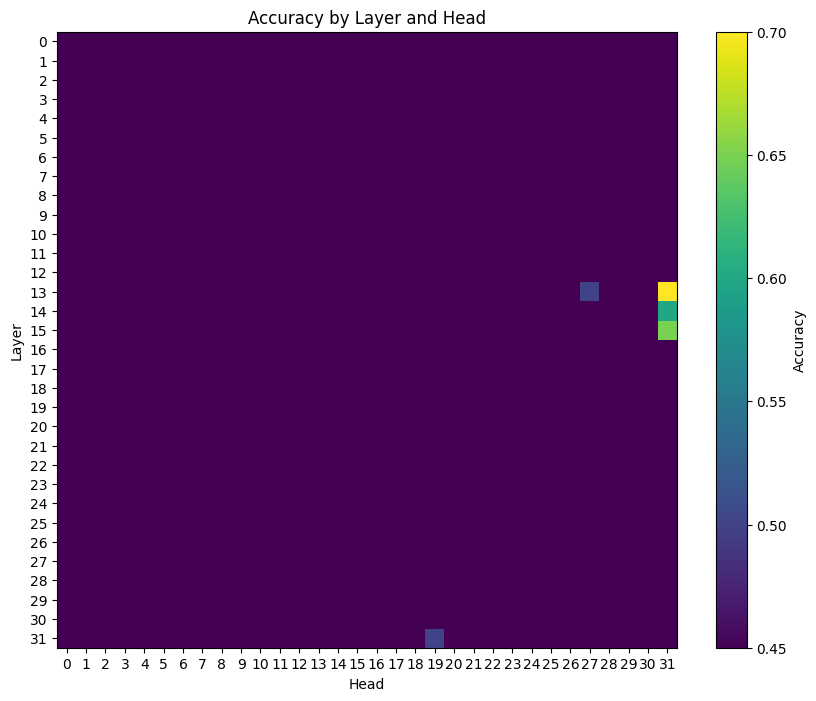

In [11]:
# 假设以下数据已经定义：representation_array_v, representation_array_nv, labels_v, labels_nv
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads

# 创建一个矩阵存储每个 layer 和 head 的 accuracy
accuracy_matrix = np.zeros((num_layers, num_heads))

# 遍历每个 layer 和 head，计算 accuracy
for i in range(num_layers):
    for j in range(num_heads):
        rep_v_x = representation_array_v[:, j, i, 0, :]
        rep_nv_x = representation_array_nv[:, j, i, 0, :]

        X = np.concatenate((rep_v_x, rep_nv_x), axis=0)
        y = np.concatenate((labels_v, labels_nv), axis=0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

        # Logistic Regression
        classifier = LogisticRegression(penalty='l2', max_iter=1000)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        # 存储到矩阵中
        accuracy_matrix[i, j] = accuracy

# 绘制热力图
plt.figure(figsize=(10, 8))
plt.imshow(accuracy_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Accuracy')
plt.title('Accuracy by Layer and Head')
plt.xlabel('Head')
plt.ylabel('Layer')
plt.xticks(np.arange(num_heads))
plt.yticks(np.arange(num_layers))
plt.show()

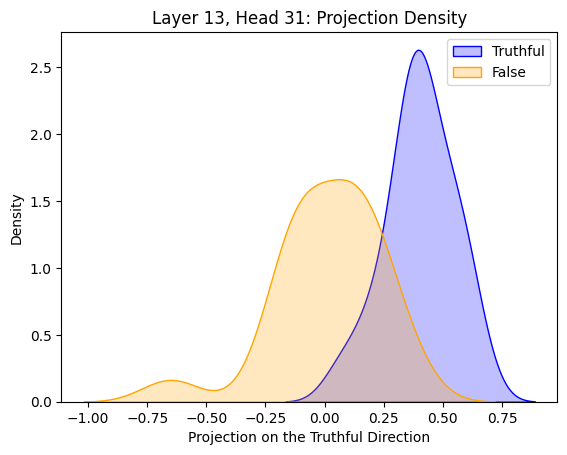

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 假设以下数据已经定义
# representation_array_v, representation_array_nv, labels_v, labels_nv

# 定义需要的层和head
target_layer = 13  # 第13层 (从0开始索引)
target_head = 31  # 第31个head (从0开始索引)

# 提取目标层和head的表示
rep_v_x = representation_array_v[:, target_head, target_layer, 0, :]
rep_nv_x = representation_array_nv[:, target_head, target_layer, 0, :]

# 合并数据和标签
X = np.concatenate((rep_v_x, rep_nv_x), axis=0)
y = np.concatenate((labels_v, labels_nv), axis=0)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Logistic Regression
classifier = LogisticRegression(penalty='l2', max_iter=1000)
classifier.fit(X_train, y_train)

# 获取投影方向
projection_direction = classifier.coef_[0]  # 分类器权重作为投影方向

# 投影数据到该方向
projections = X @ projection_direction

# 分别获取真实和错误样本的投影
projections_v = projections[:len(rep_v_x)]
projections_nv = projections[len(rep_v_x):]

# 绘制核密度估计图
import seaborn as sns

sns.kdeplot(projections_v, label="Truthful", color="blue", fill=True)
sns.kdeplot(projections_nv, label="False", color="orange", fill=True)

plt.xlabel("Projection on the Truthful Direction")
plt.ylabel("Density")
plt.title(f"Layer {target_layer}, Head {target_head}: Projection Density")
plt.legend()
plt.show()


/tmp/ipykernel_7510/3274290236.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


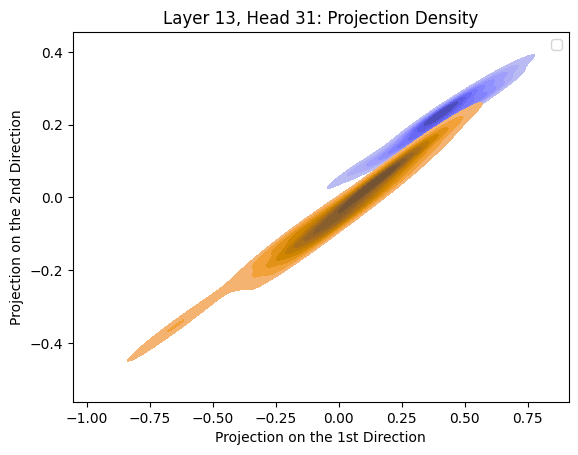

In [14]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 假设以下数据已经定义
# representation_array_v, representation_array_nv, labels_v, labels_nv

# 定义需要的层和head
target_layer = 13  # 第13层 (从0开始索引)
target_head = 31  # 第31个head (从0开始索引)

# 提取目标层和head的表示
rep_v_x = representation_array_v[:, target_head, target_layer, 0, :]
rep_nv_x = representation_array_nv[:, target_head, target_layer, 0, :]

# 合并数据和标签
X = np.concatenate((rep_v_x, rep_nv_x), axis=0)
y = np.concatenate((labels_v, labels_nv), axis=0)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Logistic Regression
classifier = LogisticRegression(penalty='l2', max_iter=1000)
classifier.fit(X_train, y_train)

# 获取第一个投影方向（基于逻辑回归权重）
direction_1 = classifier.coef_[0]  # 第一个投影方向

# 找到第二个投影方向（使用 PCA）
# 将第一方向的影响去除
X_residual = X - np.outer(X @ direction_1, direction_1)  # 去掉与第一方向的投影部分
pca = PCA(n_components=1)  # 只保留一个主成分
pca.fit(X_residual)
direction_2 = pca.components_[0]  # 第二个投影方向

# 投影到两个方向
projection_1 = X @ direction_1  # 投影到第一个方向
projection_2 = X @ direction_2  # 投影到第二个方向

# 分别获取真实和错误样本的投影
proj_v_1 = projection_1[:len(rep_v_x)]
proj_nv_1 = projection_1[len(rep_v_x):]
proj_v_2 = projection_2[:len(rep_v_x)]
proj_nv_2 = projection_2[len(rep_v_x):]

# 绘制二维核密度估计图
sns.kdeplot(x=proj_v_1, y=proj_v_2, label="Truthful", color="blue", fill=True)
sns.kdeplot(x=proj_nv_1, y=proj_nv_2, label="False", color="orange", fill=True)

plt.xlabel("Projection on the 1st Direction")
plt.ylabel("Projection on the 2nd Direction")
plt.title(f"Layer {target_layer}, Head {target_head}: Projection Density")
plt.legend()
plt.show()
